# RLMRec Result Analysis (Amazon)

This notebook analyzes the recommendation outputs from different models, examining:
...

In [1]:
# Configuration
DATASET = 'amazon'  # Change to 'amazon' or 'yelp' as needed
MODEL = 'lightgcn_plus'  # Change to other model names as needed

In [2]:
import itertools
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Config

In [7]:
# Paths
BASE_DIR = Path('.')
DATA_DIR = BASE_DIR / 'data' / DATASET
EXPORT_DIR = BASE_DIR / 'encoder' / 'exports'
PROFILE_EXPORT_DIR = BASE_DIR / 'data' / 'exports'
ANALYSIS_DIR = BASE_DIR / 'analysis' / DATASET / MODEL
os.makedirs(ANALYSIS_DIR, exist_ok=True)

# Files
RECS_FILE = EXPORT_DIR / f'recs_{MODEL}_{DATASET}.csv'
USER_PROFILES_FILE = PROFILE_EXPORT_DIR / f'{DATASET}_user_profiles.csv'
ITEM_PROFILES_FILE = PROFILE_EXPORT_DIR / f'{DATASET}_item_profiles.csv'

# Pickle files
USR_EMB_PKL = DATA_DIR / 'usr_emb_np.pkl'
ITM_EMB_PKL = DATA_DIR / 'itm_emb_np.pkl'
USR_PRF_PKL = DATA_DIR / 'usr_prf.pkl'
ITM_PRF_PKL = DATA_DIR / 'itm_prf.pkl'

print(f"Analyzing: {MODEL} on {DATASET}")
print(f"Recommendations file: {RECS_FILE}")
print(f"Files exist: {RECS_FILE.exists()}")

Analyzing: lightgcn_plus on amazon
Recommendations file: encoder/exports/recs_lightgcn_plus_amazon.csv
Files exist: True


# Load Data

In [8]:
# Load recommendations CSV
print("Loading recommendations...")
df_recs = pd.read_csv(RECS_FILE)
print(f"Loaded {len(df_recs)} users")

# Load user and item profiles
print("\nLoading profiles...")
df_users = pd.read_csv(USER_PROFILES_FILE)
df_items = pd.read_csv(ITEM_PROFILES_FILE)
print(f"Loaded {len(df_users)} user profiles and {len(df_items)} item profiles")

# Load embeddings
print("\nLoading embeddings...")
with open(USR_EMB_PKL, 'rb') as f:
    usr_emb = pickle.load(f)
with open(ITM_EMB_PKL, 'rb') as f:
    itm_emb = pickle.load(f)
print(f"User embeddings: {usr_emb.shape}, Item embeddings: {itm_emb.shape}")

# Load full profile dictionaries
print("\nLoading profile dictionaries...")
with open(USR_PRF_PKL, 'rb') as f:
    usr_prf_dict = pickle.load(f)
with open(ITM_PRF_PKL, 'rb') as f:
    itm_prf_dict = pickle.load(f)

print("\nData loaded successfully!")
df_recs.head()

Loading recommendations...
Loaded 9860 users

Loading profiles...
Loaded 11000 user profiles and 9332 item profiles

Loading embeddings...
User embeddings: (11000, 1536), Item embeddings: (9332, 1536)

Loading profile dictionaries...

Data loaded successfully!


,user_id_int,n_train_interactions,train_item_ids,test_item_ids,topk_item_ids,topk_scores,recall@5,recall@10,recall@20,ndcg@5,ndcg@10,ndcg@20
0,0,3,0|1|2,164,37|3910|1175|1450|6335|5013|3123|5165|4814|145...,11.491179|10.794396|10.434474|9.870346|9.70157...,0.0,0.0,0.000000,0.0,0.0,0.000000
1,1,28,3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20...,268|1905|1972|2530|2978|3129|4335|4954|6430|6642,1071|489|577|131|578|944|490|207|3117|329|932|...,14.874600|14.056206|12.789712|12.579494|12.572...,0.0,0.0,0.000000,0.0,0.0,0.000000
2,2,21,31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|4...,3|4353|4453|4587|5029|6109|7120|7405,899|4484|4086|2882|6531|880|1413|4715|2932|888...,16.352495|14.925657|14.282054|13.270306|13.186...,0.0,0.0,0.000000,0.0,0.0,0.000000
3,3,26,3|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66...,114|438|760|1204|2457|3074|3083|4392|5359|5555...,940|1629|3077|3078|968|6641|2616|973|906|105|1...,17.321512|17.114807|16.574383|16.262497|14.519...,0.0,0.0,0.066667,0.0,0.0,0.040914
4,4,27,3|77|78|79|80|81|82|83|84|85|86|87|88|89|90|91...,4577|6857,6553|8799|5438|6279|3301|7225|9239|8566|186|89...,16.041092|15.312650|13.762319|13.420453|13.305...,0.0,0.0,0.000000,0.0,0.0,0.000000


# 1. High-level Trend Analysis

In [9]:
def plot_metric_distributions(df, title="Metric distributions", save_path=None):
    metrics = [
        "recall@5", "recall@10", "recall@20",
        "ndcg@5", "ndcg@10", "ndcg@20",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.ravel()

    for ax, m in zip(axes, metrics):
        vals = df[m].dropna().values

        ax.hist(vals, bins=30, edgecolor="black")
        ax.set_title(m)
        ax.set_xlabel("value")
        ax.set_ylabel("count")
        ax.set_xlim(0, 1)

    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

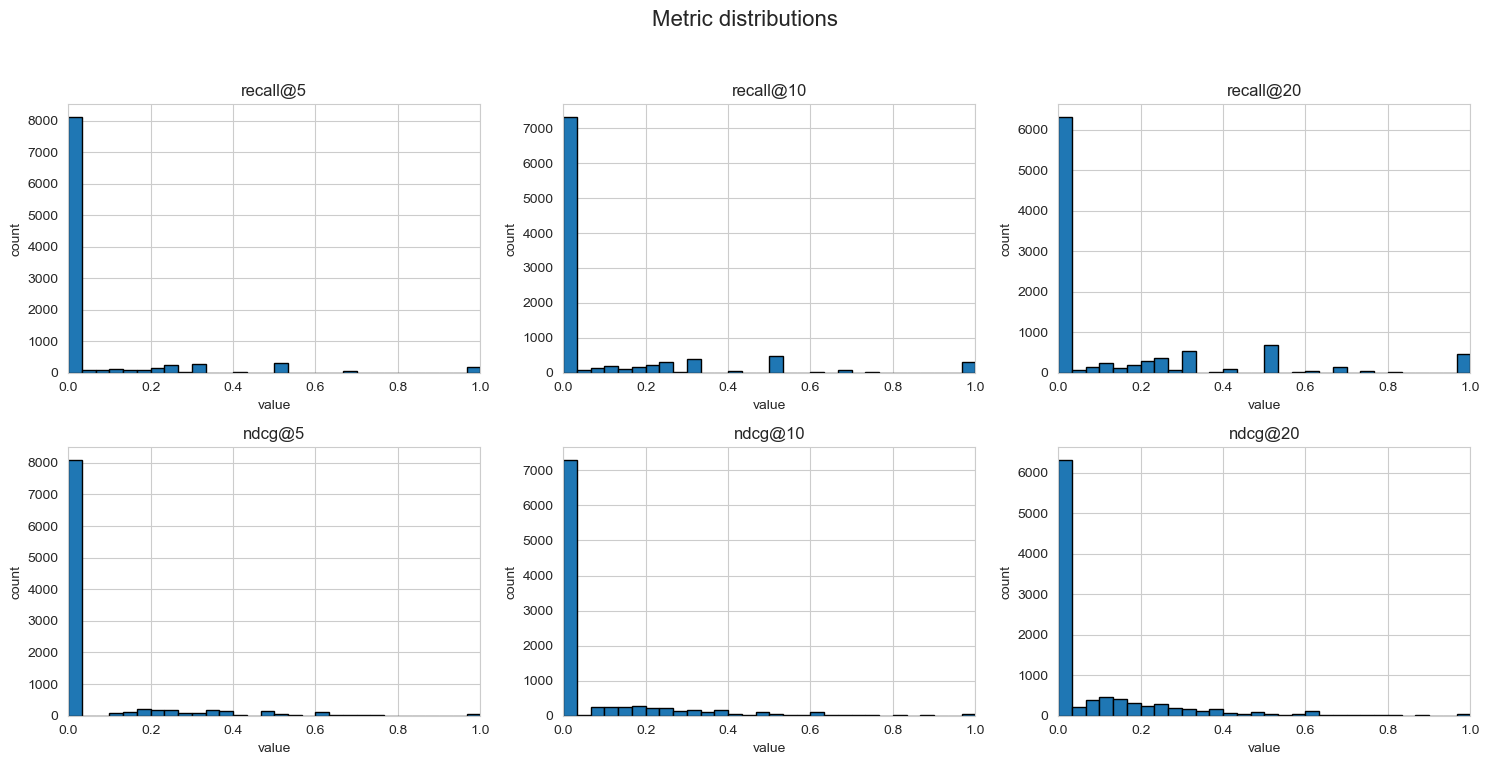

In [10]:
plot_metric_distributions(
    df_recs,
    title="Metric distributions",
    save_path=ANALYSIS_DIR / f"metric_distributions_{MODEL}_{DATASET}.png",
)

Overall, RLMRec performs relatively poorly, with its metric scores being extremely skewed and right-tailed. Thus, for the subsequent analysis of success and failure cases, we use the most lenient metric, recall@20, as the criterion for distinguishing good from bad cases.

# 2. User Segmentation by Recommendation Quality

Split users into three groups based on Recall@20:
- **Bad**: 0 recall
- **Medium**: Above zero recall, below 75th percentile
- **Good**: Above 75th percentile recall

In [11]:
# Calculate percentiles
recall_col = 'recall@20'
percentile_75 = df_recs[recall_col].quantile(0.75)

print(f"Recall@20 statistics:")
print(f"  Min: {df_recs[recall_col].min():.4f}")
print(f"  25th percentile: {df_recs[recall_col].quantile(0.25):.4f}")
print(f"  Median: {df_recs[recall_col].median():.4f}")
print(f"  75th percentile: {percentile_75:.4f}")
print(f"  Max: {df_recs[recall_col].max():.4f}")
print(f"  Mean: {df_recs[recall_col].mean():.4f}")

# Segment users
def segment_user(recall):
    if recall == 0:
        return 'Bad'
    elif recall <= percentile_75:
        return 'Medium'
    else:
        return 'Good'

df_recs['segment'] = df_recs[recall_col].apply(segment_user)

# Count users in each segment
segment_counts = df_recs['segment'].value_counts()
print(f"\nUser segmentation:")
for segment, count in segment_counts.items():
    pct = 100 * count / len(df_recs)
    print(f"  {segment}: {count} users ({pct:.1f}%)")

Recall@20 statistics:
  Min: 0.0000
  25th percentile: 0.0000
  Median: 0.0000
  75th percentile: 0.2500
  Max: 1.0000
  Mean: 0.1479

User segmentation:
  Bad: 6307 users (64.0%)
  Good: 2112 users (21.4%)
  Medium: 1441 users (14.6%)


### Histogram: Number of Train Interactions by Segment

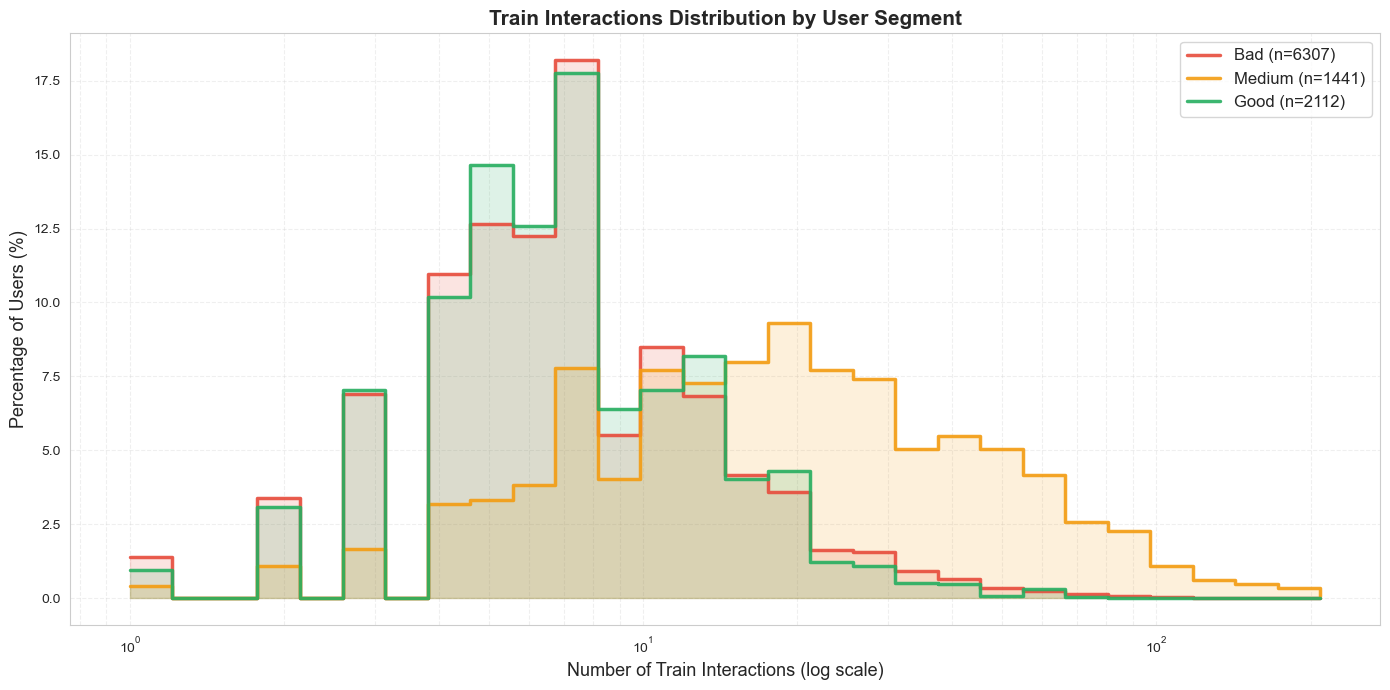


Train Interactions Statistics by Segment:
          count       mean        std  min  25%   50%   75%    max
segment                                                           
Bad      6307.0   9.003171   8.169392  1.0  5.0   7.0  10.0  109.0
Good     2112.0   8.579545   6.715602  1.0  5.0   7.0  10.0   71.0
Medium   1441.0  26.751561  26.916422  1.0  9.0  18.0  34.0  253.0

Segment Statistics:
Bad: Mean=9.0, Median=7.0
Medium: Mean=26.8, Median=18.0
Good: Mean=8.6, Median=7.0


In [12]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

segments = ['Bad', 'Medium', 'Good']
colors = ['#e74c3c', '#f39c12', '#27ae60']

# Determine shared bins based on all data - use log scale bins
all_data = df_recs['n_train_interactions']
bins = np.logspace(np.log10(all_data.min()), np.log10(all_data.max()), 30)

# Plot all three segments with step histograms (clearer than overlapping bars)
for segment, color in zip(segments, colors):
    segment_data = df_recs[df_recs['segment'] == segment]['n_train_interactions']
    # Calculate histogram values
    counts, bin_edges = np.histogram(segment_data, bins=bins)
    # Convert to percentages
    percentages = (counts / len(segment_data)) * 100
    # Plot as step histogram (line style)
    ax.plot(bin_edges[:-1], percentages, drawstyle='steps-post', color=color, 
            linewidth=2.5, label=f'{segment} (n={len(segment_data)})', alpha=0.9)
    # Optionally fill under the curve with transparency
    ax.fill_between(bin_edges[:-1], percentages, step='post', color=color, alpha=0.15)

# Set log scale for x-axis
ax.set_xscale('log')

ax.set_xlabel('Number of Train Interactions (log scale)', fontsize=13)
ax.set_ylabel('Percentage of Users (%)', fontsize=13)
ax.set_title('Train Interactions Distribution by User Segment', fontsize=15, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='both', alpha=0.3, linestyle='--', which='both')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'interaction_histogram_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics by segment
print("\nTrain Interactions Statistics by Segment:")
print(df_recs.groupby('segment')['n_train_interactions'].describe())

# Print mean and median for each segment
print("\nSegment Statistics:")
for segment in segments:
    segment_data = df_recs[df_recs['segment'] == segment]['n_train_interactions']
    print(f"{segment}: Mean={segment_data.mean():.1f}, Median={segment_data.median():.1f}")

### Overall Distribution

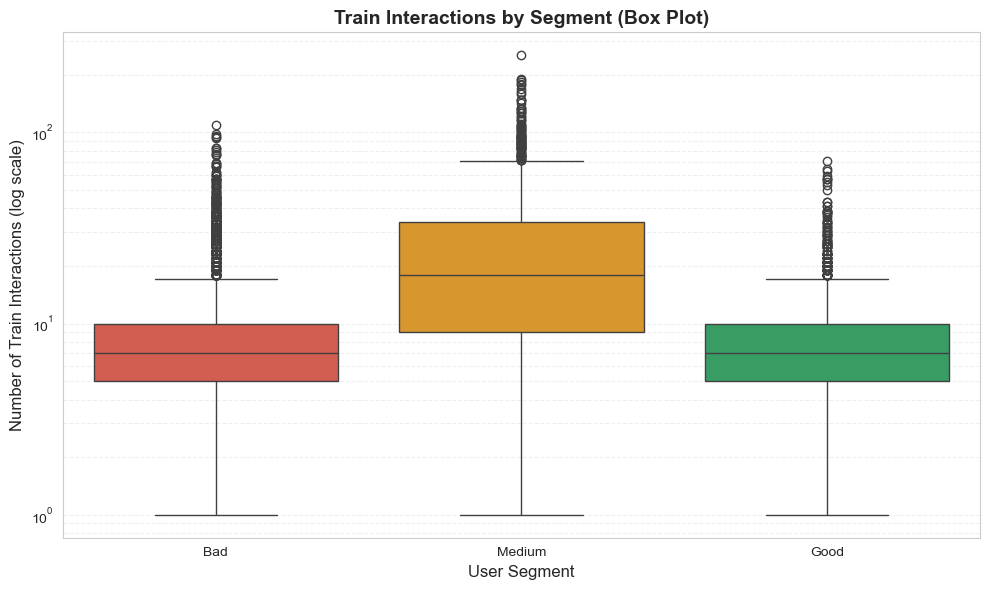

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Box plot
segment_order = ['Bad', 'Medium', 'Good']
sns.boxplot(data=df_recs, x='segment', y='n_train_interactions', order=segment_order, 
            palette={'Bad': colors[0], 'Medium': colors[1], 'Good': colors[2]}, ax=ax)

# Set log scale for y-axis
ax.set_yscale('log')

ax.set_xlabel('User Segment', fontsize=12)
ax.set_ylabel('Number of Train Interactions (log scale)', fontsize=12)
ax.set_title('Train Interactions by Segment (Box Plot)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, which='both', linestyle='--')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / f'interaction_comparison_{MODEL}_{DATASET}.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. User–Item Semantic Embedding Similarity Over Time

In [21]:
# Filter users with sufficient interactions
min_interactions = 20
df_active = df_recs[df_recs['n_train_interactions'] >= min_interactions].copy()

Computing user embedding vs historical item similarities over time...
Built trajectory DataFrame with 19880 rows for 263 users.


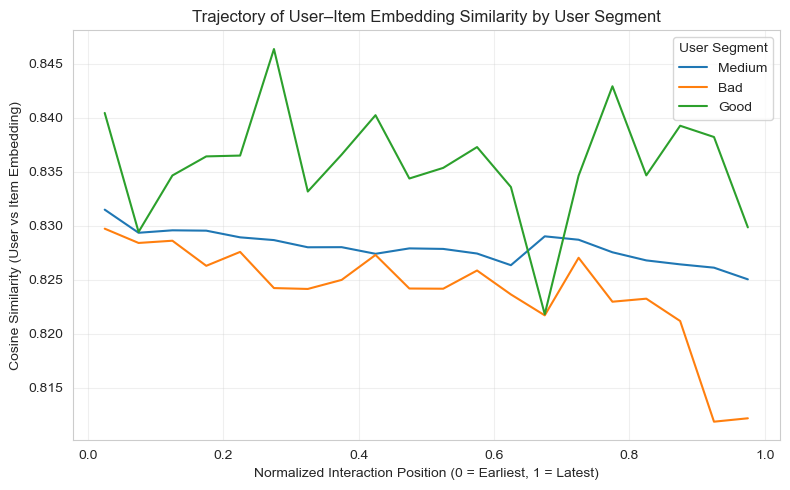

In [22]:
# --------------------------------------------------------------------
# Config
# --------------------------------------------------------------------
MIN_INTERACTIONS = 50   # only analyze users with at least this many train interactions
N_BINS = 20             # for normalized position along the history

# --------------------------------------------------------------------
# 1. Compute similarity trajectory for each user
# --------------------------------------------------------------------

def parse_id_list(id_str):
    """Parse pipe-separated ID string to list of integers."""
    if pd.isna(id_str) or id_str == '':
        return []
    return [int(x) for x in str(id_str).split('|')]

def compute_user_history_similarities(row):
    """
    For a single user:
    - Take ordered train_item_ids (earliest -> latest)
    - Compute cosine similarity between the user embedding and
      each item embedding in order.

    Returns:
        sims: np.array of shape (n_train,)
    """
    user_id = row["user_id_int"]
    train_items = parse_id_list(row["train_item_ids"])

    if len(train_items) == 0:
        return None

    # User embedding
    user_emb_vec = usr_emb[user_id].reshape(1, -1)

    # Item embeddings (ordered by time)
    train_embs = itm_emb[train_items]  # shape: (n_train, d)

    # Cosine similarity user vs each item
    sims = cosine_similarity(user_emb_vec, train_embs)[0]  # shape: (n_train,)

    return sims


print("Computing user embedding vs historical item similarities over time...")

records = []

for _, row in df_active.iterrows():
    n_train = row["n_train_interactions"]
    if n_train < MIN_INTERACTIONS:
        continue

    sims = compute_user_history_similarities(row)
    if sims is None:
        continue

    n = len(sims)
    for pos, sim in enumerate(sims):
        # pos: 0..n-1; convert to 1-based index and normalized position
        records.append({
            "user_id": row["user_id_int"],
            "segment": row["segment"],
            "recall@20": row["recall@20"],
            "n_train": n,
            "pos": pos + 1,                         # 1 = earliest
            "rel_pos": pos / (n - 1) if n > 1 else 0.0,  # 0..1
            "similarity": sim
        })

df_traj = pd.DataFrame(records)
print(
    f"Built trajectory DataFrame with {len(df_traj)} rows "
    f"for {df_traj['user_id'].nunique()} users."
)

# --------------------------------------------------------------------
# 2. Bin over normalized time
# --------------------------------------------------------------------
df_traj["pos_bin"] = pd.cut(
    df_traj["rel_pos"],
    bins=np.linspace(0, 1, N_BINS + 1),
    labels=False,
    include_lowest=True
)

# --------------------------------------------------------------------
# 3. Plot: User–Item Embedding Similarity Trajectory by Segment
# --------------------------------------------------------------------
segments = df_traj["segment"].dropna().unique()

plt.figure(figsize=(8, 5))

for seg in segments:
    df_seg = df_traj[df_traj["segment"] == seg].copy()

    df_seg["pos_bin"] = pd.cut(
        df_seg["rel_pos"],
        bins=np.linspace(0, 1, N_BINS + 1),
        labels=False,
        include_lowest=True
    )

    # Aggregate mean similarity in each normalized position bin
    df_plot_seg = (
        df_seg
        .groupby("pos_bin")["similarity"]
        .mean()
        .reset_index()
        .dropna()
    )

    df_plot_seg["pos_center"] = (df_plot_seg["pos_bin"] + 0.5) / N_BINS

    plt.plot(
        df_plot_seg["pos_center"],
        df_plot_seg["similarity"],
        label=str(seg)
    )

plt.xlabel("Normalized Interaction Position (0 = Earliest, 1 = Latest)")
plt.ylabel("Cosine Similarity (User vs Item Embedding)")
plt.title("Trajectory of User–Item Embedding Similarity by User Segment")
plt.legend(title="User Segment")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --------------------------------------------------------------------
# 4. Save the figure
# --------------------------------------------------------------------
plt.savefig(
    ANALYSIS_DIR / f"embedding_similarity_trajectory_{MODEL}_{DATASET}.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

Recommendation quality improves when the LLM-generated user embedding more faithfully captures the nuances of the items a user interacts with. Users in the Good segment consistently exhibit higher similarity between their user profile and both early and late items, indicating that the model forms a coherent and comprehensive representation of their preferences. In contrast, Medium and especially Bad users show flatter and lower similarity curves—most notably a drop near the end of their histories—suggesting that recent item-specific details are not fully reflected in their user embeddings. This gap implies that poorer recommendations arise when the user profile fails to encode the evolving peculiarities of the items a user engages with.

# 4. Statistical Testing

In [29]:
# --------------------------------------------------------------------
# Function: compute similarities for earliest and latest interactions
# --------------------------------------------------------------------
def compute_embedding_similarities(user_row, n_items=5):
    """Compute cosine similarities between user embedding and earliest/latest train items."""
    user_id = user_row['user_id_int']
    train_items = parse_id_list(user_row['train_item_ids'])
    
    # need min interactions
    if len(train_items) < n_items:
        return None, None
    
    # user embedding
    user_emb_vec = usr_emb[user_id].reshape(1, -1)
    
    # earliest n
    earliest_embs = itm_emb[train_items[:n_items]]
    avg_earliest = cosine_similarity(user_emb_vec, earliest_embs)[0].mean()
    
    # latest n
    latest_embs = itm_emb[train_items[-n_items:]]
    avg_latest = cosine_similarity(user_emb_vec, latest_embs)[0].mean()
    
    return avg_earliest, avg_latest

# --------------------------------------------------------------------
# Compute similarities for all users
# --------------------------------------------------------------------
print("Computing embedding similarities (earliest vs latest items)...")

results = []
for _, row in df_active.iterrows():
    e, l = compute_embedding_similarities(row)
    if e is not None:
        results.append({
            "user_id": row["user_id_int"],
            "segment": row["segment"],
            "avg_sim_earliest_5": e,
            "avg_sim_latest_5": l,
            "sim_diff": l - e
        })

df_sim = pd.DataFrame(results)
print(f"Computed earliest/latest similarities for {len(df_sim)} users.\n")

# --------------------------------------------------------------------
# Summary statistics
# --------------------------------------------------------------------
print("== Overall Similarity Statistics ==")
print(df_sim[["avg_sim_earliest_5", "avg_sim_latest_5", "sim_diff"]].describe(), "\n")

# --------------------------------------------------------------------
# Paired t-test (Main Significance Test)
# --------------------------------------------------------------------
t_stat, p_value = stats.ttest_rel(
    df_sim["avg_sim_latest_5"],
    df_sim["avg_sim_earliest_5"]
)

print("== Paired t-test: Latest vs Earliest ==")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.001:
    print("Conclusion: Highly significant difference (p < 0.001)")
elif p_value < 0.05:
    print("Conclusion: Significant difference (p < 0.05)")
else:
    print("Conclusion: No significant difference (p >= 0.05)")

Computing embedding similarities (earliest vs latest items)...
Computed earliest/latest similarities for 1251 users.

== Overall Similarity Statistics ==
       avg_sim_earliest_5  avg_sim_latest_5     sim_diff
count         1251.000000       1251.000000  1251.000000
mean             0.832391          0.827374    -0.005017
std              0.015733          0.022301     0.021233
min              0.783413          0.652819    -0.191737
25%              0.821768          0.816379    -0.014406
50%              0.832893          0.830135    -0.003357
75%              0.843948          0.840942     0.006653
max              0.885766          0.874988     0.051803 

== Paired t-test: Latest vs Earliest ==
t-statistic: -8.3572
p-value: 0.000000
Conclusion: Highly significant difference (p < 0.001)


To quantify whether users are, on average, more semantically aligned with their earliest or latest interacted items, we compared the LLM-generated user embedding against the first and last five items for each user. Across 1,251 users, the mean similarity to earliest items (0.8324) was slightly higher than the mean similarity to most recent items (0.8274), and this difference was highly significant (paired t-test, t = −8.36, p < 0.001). This confirms that the shift in user–item embedding alignment over the interaction trajectory is not random noise but a systematic effect: users’ latest items tend to be less well captured in their final user representation. This aligns with the earlier qualitative observation that weaker segments—especially Bad users—show diminishing semantic alignment with recent items, suggesting that the user profile generated by the LLM may not fully incorporate evolving item-specific details for lower-quality cases.

# 5. Qualitative Analysis

Note: Other datasets may need to swap user_id for user_id_int from the start

In [31]:
# For amazon data
# df_users.rename(columns={"reviewer_id_raw": "user_id_raw"}, inplace=True)
# df_items.rename(columns={"asin_raw": "item_id_raw"}, inplace=True)

In [36]:
# --------------------------------------------------------------------
# Compute per-user front/back similarity summary (first 5 & last 5)
# --------------------------------------------------------------------
K = 5  # number of items at the front/back to use

def get_item_profile(item_id_int):
    """Get item profile text by integer ID."""
    match = df_items[df_items['item_id_int'] == item_id_int]
    if len(match) > 0:
        return {
            'item_id_raw': match.iloc[0]['item_id_raw'],
            'profile': match.iloc[0]['profile_text']
        }
    return {'item_id_raw': 'N/A', 'profile': 'Profile not found'}

def get_user_full_profile(user_id_int):
    """Get full user profile from pickle dictionary."""
    if user_id_int in usr_prf_dict:
        return usr_prf_dict[user_id_int]
    return {'profile': 'N/A', 'reasoning': 'N/A'}

def summarize_front_back(group):
    # make sure ordered by pos
    g = group.sort_values('pos')
    sims = g['similarity'].values
    
    front = sims[:K]
    back = sims[-K:]
    
    return pd.Series({
        'n_train': g['n_train'].iloc[0],
        'front_mean_sim': front.mean(),
        'back_mean_sim': back.mean(),
        'fb_mean_sim': np.concatenate([front, back]).mean(),  # mean over front+back
    })

df_user_fb = (
    df_traj
    .groupby(['user_id', 'segment'], as_index=False)
    .apply(summarize_front_back)
    .reset_index(drop=True)
)

df_user_fb = df_user_fb.rename(columns={'user_id': 'user_id_int'})

def print_user_analysis(user_row):
    """Print qualitative analysis for a single user."""
    user_id = user_row['user_id_int']
    segment = user_row['segment']
    
    print("="*100)
    print(f"USER ID: {user_id}")
    print(f"Segment: {segment}")
    print(f"Number of train interactions: {user_row['n_train_interactions']}")
    print(f"Recall@20: {user_row['recall@20']:.4f}")
    print(f"NDCG@20: {user_row['ndcg@20']:.4f}")
    
    # Optional: show front/back similarity stats if available
    if 'front_mean_sim' in user_row.index and pd.notna(user_row['front_mean_sim']):
        print(f"Front-5 mean sim (user ↔ item): {user_row['front_mean_sim']:.4f}")
    if 'back_mean_sim' in user_row.index and pd.notna(user_row['back_mean_sim']):
        print(f"Back-5 mean sim  (user ↔ item): {user_row['back_mean_sim']:.4f}")
    if 'fb_mean_sim' in user_row.index and pd.notna(user_row['fb_mean_sim']):
        print(f"Front+Back mean  (user ↔ item): {user_row['fb_mean_sim']:.4f}")
    
    print("="*100)
    
    # Get user profile from CSV
    user_profile_csv = df_users[df_users['user_id_int'] == user_id]
    if len(user_profile_csv) > 0:
        print(f"\n{'USER ID (RAW):':<25} {user_profile_csv.iloc[0]['user_id_raw']}")
    
    # Get full user profile from pickle
    user_full_profile = get_user_full_profile(user_id)
    print(f"\n{'USER PROFILE:':<25}")
    print(f"{user_full_profile.get('profile', 'N/A')}")
    print(f"\n{'USER REASONING:':<25}")
    print(f"{user_full_profile.get('reasoning', 'N/A')}")
    
    # Parse item lists
    train_items = parse_id_list(user_row['train_item_ids'])
    test_items = parse_id_list(user_row['test_item_ids'])
    pred_items = parse_id_list(user_row['topk_item_ids'])
    pred_scores = [float(x) for x in str(user_row['topk_scores']).split('|')] if pd.notna(user_row['topk_scores']) else []
    
    # Historical interactions (train items)
    print(f"\n{'-'*100}")
    print(f"HISTORICAL INTERACTIONS (TRAIN): {len(train_items)} items")
    print(f"{'-'*100}")

    if len(train_items) <= 10:
        # Show all in chronological order
        for idx, item_id in enumerate(train_items, 1):
            item_info = get_item_profile(item_id)
            print(f"\n[{idx}] Item ID: {item_id} (Raw: {item_info['item_id_raw']})")
            print(f"    {item_info['profile']}")
    else:
        # Earliest K
        print(f"\nEarliest {K} train items:")
        first_part = train_items[:K]
        for offset, item_id in enumerate(first_part, 1):
            item_info = get_item_profile(item_id)
            print(f"\n[{offset}] Item ID: {item_id} (Raw: {item_info['item_id_raw']})")
            print(f"    {item_info['profile']}")

        # Latest K
        print(f"\nLatest {K} train items:")
        last_part = train_items[-K:]
        start_idx = len(train_items) - K + 1
        for idx, item_id in zip(range(start_idx, len(train_items) + 1), last_part):
            item_info = get_item_profile(item_id)
            print(f"\n[{idx}] Item ID: {item_id} (Raw: {item_info['item_id_raw']})")
            print(f"    {item_info['profile']}")

        print("\n... showing earliest and latest 5 items only")

    # Predicted items (recommendations)
    print(f"\n{'-'*100}")
    print("PREDICTED ITEMS (TOP-5 RECOMMENDATIONS)")
    print(f"{'-'*100}")
    for i, (item_id, score) in enumerate(zip(pred_items[:5], pred_scores[:5]), 1):  # Show top 5
        item_info = get_item_profile(item_id)
        in_test = '✓ HIT' if item_id in test_items else '✗ MISS'
        print(f"\n[{i}] Item ID: {item_id} (Raw: {item_info['item_id_raw']}) | Score: {score:.4f} | {in_test}")
        print(f"    {item_info['profile']}")

    # Actual test items (ground truth)
    print(f"\n{'-'*100}")
    print(f"GROUND TRUTH (TEST ITEMS): {len(test_items)} items")
    print(f"{'-'*100}")
    for i, item_id in enumerate(test_items, 1):
        item_info = get_item_profile(item_id)
        in_pred = '✓ PREDICTED' if item_id in pred_items else '✗ NOT PREDICTED'
        print(f"\n[{i}] Item ID: {item_id} (Raw: {item_info['item_id_raw']}) | {in_pred}")
        print(f"    {item_info['profile']}")
    
    print("\n" + "="*100 + "\n")


from io import StringIO
from contextlib import redirect_stdout

min_train_interactions = 50  # keep this if you want an extra filter
np.random.seed(42)

# Merge similarity summary into df_recs so print_user_analysis can see it
df_recs_with_sim = df_recs.merge(
    df_user_fb[['user_id_int', 'segment', 'front_mean_sim', 'back_mean_sim', 'fb_mean_sim']],
    on=['user_id_int', 'segment'],
    how='inner'
)

# Optionally keep only users with enough train interactions
df_recs_with_sim = df_recs_with_sim[
    df_recs_with_sim['n_train_interactions'] > min_train_interactions
]

selected_rows = []

# Helper to pick users per segment based on front+back similarity
def pick_user_for_segment(seg, ascending):
    seg_users = df_recs_with_sim[df_recs_with_sim['segment'] == seg]
    if len(seg_users) == 0:
        return None
    # ascending=True -> lowest fb_mean_sim
    # ascending=False -> highest fb_mean_sim
    return seg_users.sort_values('fb_mean_sim', ascending=ascending).iloc[[0]]

# Bad: low front+back similarity
bad_row = pick_user_for_segment('Bad', ascending=True)
if bad_row is not None:
    selected_rows.append(bad_row)

# Medium: low front+back similarity
med_row = pick_user_for_segment('Medium', ascending=True)
if med_row is not None:
    selected_rows.append(med_row)

# Good: high front+back similarity
good_row = pick_user_for_segment('Good', ascending=False)
if good_row is not None:
    selected_rows.append(good_row)

if len(selected_rows) > 0:
    selected_users = pd.concat(selected_rows, ignore_index=True)
else:
    selected_users = pd.DataFrame(columns=df_recs_with_sim.columns)

# Output file name
output_file_qual = ANALYSIS_DIR / f'qualitative_examples_{MODEL}_{DATASET}.txt'

buf = StringIO()

with redirect_stdout(buf):
    if len(selected_users) == 0:
        print("No users available for qualitative analysis.")
    else:
        print(f"\n\n{'#'*100}")
        print("QUALITATIVE USER EXAMPLES BY SEGMENT")
        print(f"{'#'*100}\n")

        for idx, (_, user_row) in enumerate(selected_users.iterrows(), 1):
            seg = user_row['segment']
            fb_sim = user_row['fb_mean_sim']
            
            print(f"\n>>> Example {idx}/{len(selected_users)} from {seg} segment "
                  f"(front+back mean similarity = {fb_sim:.4f}) <<<\n")
            print_user_analysis(user_row)

# Extract what was printed
output_text = buf.getvalue()

# Print to notebook
print(output_text)

# Save to file
with open(output_file_qual, 'w', encoding='utf-8') as f:
    f.write(f"Qualitative User Examples: {MODEL} on {DATASET}\n")
    f.write(f"{'='*100}\n\n")
    f.write(output_text)

print("\n" + "="*100)
print(f"Qualitative user examples saved to: {output_file_qual}")
print("="*100)



####################################################################################################
QUALITATIVE USER EXAMPLES BY SEGMENT
####################################################################################################


>>> Example 1/3 from Bad segment (front+back mean similarity = 0.7483) <<<

USER ID: 1068
Segment: Bad
Number of train interactions: 93
Recall@20: 0.0000
NDCG@20: 0.0000
Front-5 mean sim (user ↔ item): 0.8297
Back-5 mean sim  (user ↔ item): 0.6669
Front+Back mean  (user ↔ item): 0.7483

USER ID (RAW):            A1RD05YFMWKM4Y

USER PROFILE:            
The user enjoys a mix of genres, including steamy romance with alpha male protagonists, young adult fantasy with a strong female lead, and emotionally charged romance novels. However, the user has a low tolerance for instant-love stories and cliffhanger endings. They are unlikely to continue reading a series if they are not satisfied with the previous book.

USER REASONING:          
From the purch